<a href="https://colab.research.google.com/github/gc2321/3546-Deep-Learning/blob/main/Module_5_RNN/chicago_transit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 [==============================] - 0s 0us/step


'./datasets/ridership.tgz'

In [5]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [6]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


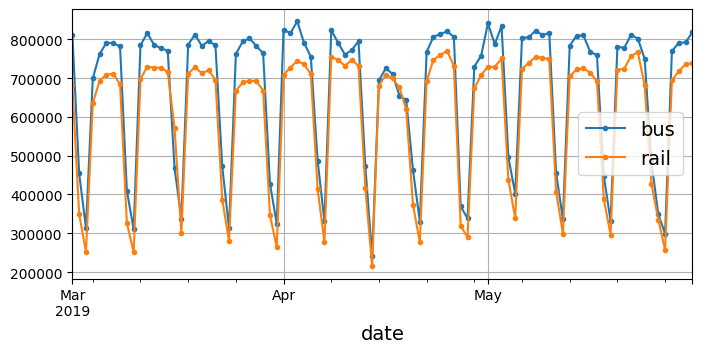

In [7]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

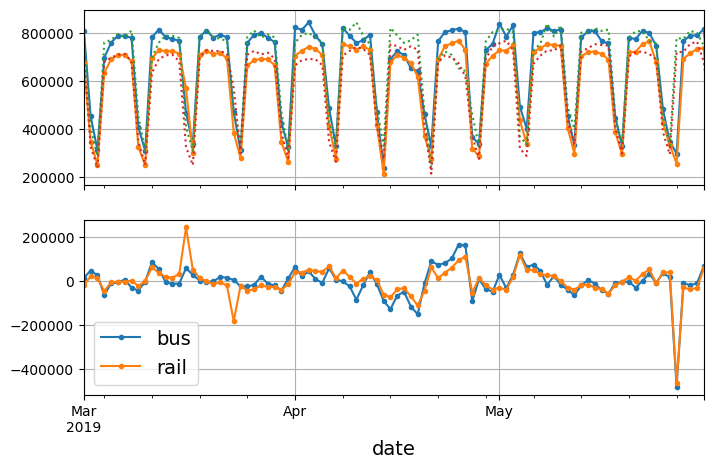

In [8]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
plt.show()

In [9]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

In [10]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

In [11]:
if "google.colab" in sys.modules:
    %pip install -q -U statsmodels

In [12]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # returns 427,758.6

In [13]:
y_pred

2019-06-01    427758.62641
Freq: D, dtype: float64

In [14]:
df["rail"].loc["2019-06-01"]  # target value

379044

In [15]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

426932

In [16]:
# forcasts for every day in March
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

In [17]:
mae

32040.720089453378

## Machine Learning

In [18]:
# split data into training period, validation period, test period, divide 1e6 to get values close to 0 - 1 range
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [19]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

## Simple RNNs

In [20]:
# extra code – defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb], verbose=0)
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [21]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [22]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 3s 38ms/step - loss: 0.0318 - mae: 0.1948 - val_loss: 0.0147 - val_mae: 0.1335
Epoch 2/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0100 - mae: 0.1130 - val_loss: 0.0054 - val_mae: 0.0894
Epoch 3/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0052 - mae: 0.0766 - val_loss: 0.0030 - val_mae: 0.0560
Epoch 4/500
33/33 [==============================] - 1s 19ms/step - loss: 0.0041 - mae: 0.0620 - val_loss: 0.0026 - val_mae: 0.0484
Epoch 5/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0034 - mae: 0.0534 - val_loss: 0.0022 - val_mae: 0.0370
Epoch 6/500
33/33 [==============================] - 2s 40ms/step - loss: 0.0034 - mae: 0.0539 - val_loss: 0.0026 - val_mae: 0.0511
Epoch 7/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0032 - mae: 0.0535 - val_loss: 0.0019 - val_mae: 0.0315
Epoch 8/500
33/33 [==============================] - 1s 27ms/step - loss: 0.

28538.648039102554

## Deep RNN

In [23]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [24]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 [==============================] - 5s 76ms/step - loss: 0.0374 - mae: 0.2045 - val_loss: 0.0131 - val_mae: 0.1547
Epoch 2/500
33/33 [==============================] - 2s 65ms/step - loss: 0.0109 - mae: 0.1218 - val_loss: 0.0057 - val_mae: 0.0905
Epoch 3/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0055 - mae: 0.0799 - val_loss: 0.0033 - val_mae: 0.0629
Epoch 4/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0043 - mae: 0.0650 - val_loss: 0.0030 - val_mae: 0.0569
Epoch 5/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0044 - mae: 0.0642 - val_loss: 0.0025 - val_mae: 0.0501
Epoch 6/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0040 - mae: 0.0608 - val_loss: 0.0023 - val_mae: 0.0452
Epoch 7/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0039 - mae: 0.0591 - val_loss: 0.0033 - val_mae: 0.0591
Epoch 8/500
33/33 [==============================] - 1s 37ms/step - loss: 0.

29692.931100726128

## Mulitivariate Time Series

In [26]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [28]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [31]:
mulvar_train.dtypes

bus                float64
rail               float64
next_day_type_A       bool
next_day_type_U       bool
next_day_type_W       bool
dtype: object

In [33]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.astype("float64").to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.astype("float64").to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [34]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

In [35]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 2s 23ms/step - loss: 0.0670 - mae: 0.2633 - val_loss: 0.0016 - val_mae: 0.0325
Epoch 2/500
33/33 [==============================] - 1s 15ms/step - loss: 0.0034 - mae: 0.0601 - val_loss: 0.0014 - val_mae: 0.0390
Epoch 3/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0018 - mae: 0.0408 - val_loss: 8.6570e-04 - val_mae: 0.0290
Epoch 4/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0015 - mae: 0.0374 - val_loss: 0.0012 - val_mae: 0.0380
Epoch 5/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0014 - mae: 0.0352 - val_loss: 9.5051e-04 - val_mae: 0.0331
Epoch 6/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0013 - mae: 0.0346 - val_loss: 0.0010 - val_mae: 0.0349
Epoch 7/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0013 - mae: 0.0348 - val_loss: 7.2845e-04 - val_mae: 0.0274
Epoch 8/500
33/33 [==============================] - 1s 27ms/ste

23526.73187851906

In [37]:
# build and train multitask RNN that forecasts both bus and rail
tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.astype("float64").to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.astype("float64").to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 2s 25ms/step - loss: 0.1019 - mae: 0.3242 - val_loss: 0.0115 - val_mae: 0.1286
Epoch 2/500
33/33 [==============================] - 1s 15ms/step - loss: 0.0044 - mae: 0.0729 - val_loss: 0.0023 - val_mae: 0.0564
Epoch 3/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0019 - mae: 0.0440 - val_loss: 0.0010 - val_mae: 0.0340
Epoch 4/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0017 - mae: 0.0422 - val_loss: 0.0018 - val_mae: 0.0492
Epoch 5/500
33/33 [==============================] - 1s 26ms/step - loss: 0.0017 - mae: 0.0421 - val_loss: 9.4581e-04 - val_mae: 0.0323
Epoch 6/500
33/33 [==============================] - 1s 25ms/step - loss: 0.0016 - mae: 0.0399 - val_loss: 0.0010 - val_mae: 0.0342
Epoch 7/500
33/33 [==============================] - 1s 25ms/step - loss: 0.0016 - mae: 0.0397 - val_loss: 8.9997e-04 - val_mae: 0.0316
Epoch 8/500
33/33 [==============================] - 1s 17ms/step - 

26052.966713905334

In [38]:
# extra code – evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

43441.63157894738

In [39]:
# extra code – evaluates the multitask RNN's forecasts both bus and rail
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.mean_absolute_error(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

3/3 [==============================] - 8s 16ms/step
bus 25983
rail 26122


## Forcasting Several Time Steps Ahead

In [41]:
## predict 14 next values

tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.astype("float64").to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.astype("float64").to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [42]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [44]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 3s 31ms/step - loss: 0.1089 - mae: 0.3465 - val_loss: 0.0241 - val_mae: 0.1837
Epoch 2/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0179 - mae: 0.1506 - val_loss: 0.0111 - val_mae: 0.1233
Epoch 3/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0120 - mae: 0.1206 - val_loss: 0.0083 - val_mae: 0.1054
Epoch 4/500
33/33 [==============================] - 1s 15ms/step - loss: 0.0099 - mae: 0.1074 - val_loss: 0.0066 - val_mae: 0.0939
Epoch 5/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0086 - mae: 0.0989 - val_loss: 0.0057 - val_mae: 0.0863
Epoch 6/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0078 - mae: 0.0927 - val_loss: 0.0050 - val_mae: 0.0807
Epoch 7/500
33/33 [==============================] - 1s 15ms/step - loss: 0.0072 - mae: 0.0881 - val_loss: 0.0045 - val_mae: 0.0759
Epoch 8/500
33/33 [==============================] - 1s 14ms/step - loss: 0.

34656.49485588074

In [49]:
import numpy as np
X = mulvar_valid.astype("float64").to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 [==============================] - 1s 565ms/step


In [50]:
Y_pred

array([[0.73465616, 0.7220743 , 0.69871974, 0.67899185, 0.37811   ,
        0.30232027, 0.65177506, 0.73025525, 0.7292769 , 0.7176138 ,
        0.6629254 , 0.4081526 , 0.2991103 , 0.6524826 ]], dtype=float32)

## Sequence-to-Sequence

In [53]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [54]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [56]:
seq2seq_train = to_seq2seq_dataset(mulvar_train.astype("float64"), shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid.astype("float64"))

In [57]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

In [ ]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500
33/33 [==============================] - 4s 47ms/step - loss: 0.0830 - mae: 0.2906 - val_loss: 0.0196 - val_mae: 0.1474
Epoch 2/500
33/33 [==============================] - 1s 25ms/step - loss: 0.0123 - mae: 0.1197 - val_loss: 0.0093 - val_mae: 0.0997
Epoch 3/500
33/33 [==============================] - 1s 26ms/step - loss: 0.0079 - mae: 0.0921 - val_loss: 0.0070 - val_mae: 0.0826
Epoch 4/500
33/33 [==============================] - 1s 25ms/step - loss: 0.0062 - mae: 0.0786 - val_loss: 0.0058 - val_mae: 0.0734
Epoch 5/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0055 - mae: 0.0720 - val_loss: 0.0052 - val_mae: 0.0677
Epoch 6/500
33/33 [==============================] - 2s 44ms/step - loss: 0.0050 - mae: 0.0679 - val_loss: 0.0052 - val_mae: 0.0684
Epoch 7/500
33/33 [==============================] - 1s 23ms/step - loss: 0.0048 - mae: 0.0649 - val_loss: 0.0046 - val_mae: 0.0621
Epoch 8/500
33/33 [==============================] - 1s 23ms/step - loss: 0.